In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [2]:
%%time
data = pd.DataFrame()
for i in range(2010, 2019):
    tmp = pd.read_csv(f'../input/mlbplaybyplay2010s/all{i}.csv')
    tmp['YEAR'] = i
    data = data.append(tmp)
data = data.reset_index(drop=True)

In [3]:
single, double, triple, homerun = 20, 21, 22, 23
bb_hbp = [14, 15, 16]

In [4]:
bat_event_counts = data.groupby(['BAT_ID', 'YEAR'])['EVENT_CD'].value_counts()
pit_event_counts = data.groupby(['PIT_ID', 'YEAR'])['EVENT_CD'].value_counts()

In [5]:
%%time
bat_info = {}
for bat_id in bat_event_counts.index.get_level_values(0).unique():
    bat_info[bat_id] = {}
    for year in bat_event_counts[bat_id].index.get_level_values(0).unique():
        bat_info[bat_id][year] = {'pa': 0, 'single': 0, 'double': 0, 'triple': 0, 'homerun': 0, 'bb+hbp': 0}

        bat_info[bat_id][year]['pa'] = bat_event_counts[bat_id][year].sum()
        
        if single in bat_event_counts[bat_id][year].index:
            bat_info[bat_id][year]['single'] = bat_event_counts[bat_id][year][single].sum()
            
        if double in bat_event_counts[bat_id][year].index:
            bat_info[bat_id][year]['double'] = bat_event_counts[bat_id][year][double].sum()
            
        if triple in bat_event_counts[bat_id][year].index:
            bat_info[bat_id][year]['triple'] = bat_event_counts[bat_id][year][triple].sum()
            
        if homerun in bat_event_counts[bat_id][year].index:
            bat_info[bat_id][year]['homerun'] = bat_event_counts[bat_id][year][homerun].sum()
        
        existing_events = bat_event_counts[bat_id][year].index.intersection(bb_hbp)
        bat_info[bat_id][year]['bb+hbp'] = bat_event_counts[bat_id][year][existing_events].sum()

In [26]:
bat_info

{'aardd001': {2015: {'pa': 1,
   'single': 0,
   'double': 0,
   'triple': 0,
   'homerun': 0,
   'bb+hbp': 0}},
 'abadf001': {2010: {'pa': 1,
   'single': 0,
   'double': 0,
   'triple': 0,
   'homerun': 0,
   'bb+hbp': 0},
  2012: {'pa': 7,
   'single': 1,
   'double': 0,
   'triple': 0,
   'homerun': 0,
   'bb+hbp': 0},
  2016: {'pa': 1,
   'single': 0,
   'double': 0,
   'triple': 0,
   'homerun': 0,
   'bb+hbp': 0}},
 'abreb001': {2010: {'pa': 695,
   'single': 84,
   'double': 41,
   'triple': 1,
   'homerun': 20,
   'bb+hbp': 89},
  2011: {'pa': 621,
   'single': 88,
   'double': 30,
   'triple': 1,
   'homerun': 8,
   'bb+hbp': 79},
  2012: {'pa': 270,
   'single': 38,
   'double': 11,
   'triple': 1,
   'homerun': 3,
   'bb+hbp': 37},
  2014: {'pa': 157,
   'single': 23,
   'double': 9,
   'triple': 0,
   'homerun': 1,
   'bb+hbp': 20}},
 'abrej003': {2014: {'pa': 644,
   'single': 103,
   'double': 35,
   'triple': 2,
   'homerun': 36,
   'bb+hbp': 62},
  2015: {'pa': 695,
  

In [6]:
%%time
pit_info = {}
for pit_id in pit_event_counts.index.get_level_values(0).unique():
    pit_info[pit_id] = {}
    for year in pit_event_counts[pit_id].index.get_level_values(0).unique():
        pit_info[pit_id][year] = {'pa': 0, 'single': 0, 'double': 0, 'triple': 0, 'homerun': 0, 'bb+hbp': 0}
        
        pit_info[pit_id][year]['pa'] = pit_event_counts[pit_id][year].sum()
        
        if single in pit_event_counts[pit_id][year].index:
            pit_info[pit_id][year]['single'] = pit_event_counts[pit_id][year][single].sum()
            
        if double in pit_event_counts[pit_id][year].index:
            pit_info[pit_id][year]['double'] = pit_event_counts[pit_id][year][double].sum()
            
        if triple in pit_event_counts[pit_id][year].index:
            pit_info[pit_id][year]['triple'] = pit_event_counts[pit_id][year][triple].sum()
            
        if homerun in pit_event_counts[pit_id][year].index:
            pit_info[pit_id][year]['homerun'] = pit_event_counts[pit_id][year][homerun].sum()
        
        existing_events = pit_event_counts[pit_id][year].index.intersection(bb_hbp)
        pit_info[pit_id][year]['bb+hbp'] = pit_event_counts[pit_id][year][existing_events].sum()

In [9]:
%%time
bat_features = ['single/pa', 'double/pa', 'triple/pa', 'homerun/pa', '(bb+hbp)/pa']
pit_features = ['single/pa', 'double/pa', 'triple/pa', 'homerun/pa', '(bb+hbp)/pa']

data_dict = {}
data_dict[('is_home',)] = []
for i in range(9):
    for feature in bat_features:
        data_dict[(f'bat_{i+1}', feature)] = []
for feature in pit_features:
    data_dict[('starting_pit', feature)] = []
data_dict[('score',)] = []

game_end_indices = data.index[data['GAME_END_FL'] == 'T'].tolist()

start_index = 0
for end_index in game_end_indices:
    this_game = data.iloc[start_index:end_index+1]

    away_starting_bats = list(this_game['BAT_ID'][this_game['BAT_HOME_ID'] == 0].iloc[:9])
    home_starting_bats = list(this_game['BAT_ID'][this_game['BAT_HOME_ID'] == 1].iloc[:9])
    away_starting_pit = this_game['PIT_ID'][this_game['BAT_HOME_ID'] == 1].iloc[0]
    home_starting_pit = this_game['PIT_ID'][this_game['BAT_HOME_ID'] == 0].iloc[0]
    year = this_game.iloc[0]['YEAR']

    # away batters and home pitcher.
    data_dict[('is_home',)].append(0)
    for i in range(9):
        bat = away_starting_bats[i]
        pa = bat_info[bat][year]['pa']
        data_dict[(f'bat_{i+1}', 'single/pa')].append(bat_info[bat][year]['single'] / pa)
        data_dict[(f'bat_{i+1}', 'double/pa')].append(bat_info[bat][year]['double'] / pa)
        data_dict[(f'bat_{i+1}', 'triple/pa')].append(bat_info[bat][year]['triple'] / pa)
        data_dict[(f'bat_{i+1}', 'homerun/pa')].append(bat_info[bat][year]['homerun'] / pa)
        data_dict[(f'bat_{i+1}', '(bb+hbp)/pa')].append(bat_info[bat][year]['bb+hbp'] / pa)
        # data_dict[(f'bat_{i+1}', 'pa')].append(pa)
    pit = home_starting_pit
    pa = pit_info[pit][year]['pa']
    data_dict[('starting_pit', 'single/pa')].append(pit_info[pit][year]['single'] / pa)
    data_dict[('starting_pit', 'double/pa')].append(pit_info[pit][year]['double'] / pa)
    data_dict[('starting_pit', 'triple/pa')].append(pit_info[pit][year]['triple'] / pa)
    data_dict[('starting_pit', 'homerun/pa')].append(pit_info[pit][year]['homerun'] / pa)
    data_dict[('starting_pit', '(bb+hbp)/pa')].append(pit_info[pit][year]['bb+hbp'] / pa)
    # data_dict[('starting_pit', 'pa')].append(pa)
    data_dict[('score',)].append(this_game['AWAY_SCORE_CT'].iloc[-1])

    # home batters and away pitcher.
    data_dict[('is_home',)].append(1)
    for i in range(9):
        bat = home_starting_bats[i]
        pa = bat_info[bat][year]['pa']
        data_dict[(f'bat_{i+1}', 'single/pa')].append(bat_info[bat][year]['single'] / pa)
        data_dict[(f'bat_{i+1}', 'double/pa')].append(bat_info[bat][year]['double'] / pa)
        data_dict[(f'bat_{i+1}', 'triple/pa')].append(bat_info[bat][year]['triple'] / pa)
        data_dict[(f'bat_{i+1}', 'homerun/pa')].append(bat_info[bat][year]['homerun'] / pa)
        data_dict[(f'bat_{i+1}', '(bb+hbp)/pa')].append(bat_info[bat][year]['bb+hbp'] / pa)
        # data_dict[(f'bat_{i+1}', 'pa')].append(pa)
    pit = away_starting_pit
    pa = pit_info[pit][year]['pa']
    data_dict[('starting_pit', 'single/pa')].append(pit_info[pit][year]['single'] / pa)
    data_dict[('starting_pit', 'double/pa')].append(pit_info[pit][year]['double'] / pa)
    data_dict[('starting_pit', 'triple/pa')].append(pit_info[pit][year]['triple'] / pa)
    data_dict[('starting_pit', 'homerun/pa')].append(pit_info[pit][year]['homerun'] / pa)
    data_dict[('starting_pit', '(bb+hbp)/pa')].append(pit_info[pit][year]['bb+hbp'] / pa)
    # data_dict[('starting_pit', 'pa')].append(pa)
    data_dict[('score',)].append(this_game['HOME_SCORE_CT'].iloc[-1])
    
    start_index = end_index + 1

df = pd.DataFrame(data_dict)

Wall time: 1min 44s


In [12]:
df

is_home     bat_1                                                bat_2  \
          NaN single/pa double/pa triple/pa homerun/pa (bb+hbp)/pa single/pa   
0           0  0.178918  0.033287  0.013870   0.004161    0.088766  0.166102   
1           1  0.180301  0.030050  0.006678   0.008347    0.070117  0.120863   
2           0  0.178918  0.033287  0.013870   0.004161    0.088766  0.166102   
3           1  0.180301  0.030050  0.006678   0.008347    0.070117  0.120863   
4           0  0.178918  0.033287  0.013870   0.004161    0.088766  0.166102   
...       ...       ...       ...       ...        ...         ...       ...   
43731       1  0.192000  0.048000  0.002667   0.013333    0.130667  0.167320   
43732       0  0.141176  0.029412  0.011765   0.026471    0.058824  0.183333   
43733       1  0.192000  0.048000  0.002667   0.013333    0.130667  0.167320   
43734       0  0.141176  0.029412  0.011765   0.026471    0.058824  0.163504   
43735       1  0.144928  0.043478  0.014493   0.043478    0.086957  0.167320   

                                      ...     bat_9                       \
      double/pa triple/pa homerun/pa  ... double/pa triple/pa homerun/pa   
0      0.040678  0.008475   0.010169  ...  0.037037  0.003367   0.003367   
1      0.058993  0.001439   0.028777  ...  0.008065  0.000000   0.016129   
2      0.040678  0.008475   0.010169  ...  0.037037  0.003367   0.003367   
3      0.058993  0.001439   0.028777  ...  0.026087  0.004348   0.013043   
4      0.040678  0.008475   0.010169  ...  0.037037  0.003367   0.003367   
...         ...       ...        ...  ...       ...       ...        ...   
43731  0.035294  0.007843   0.024837  ...  0.000000  0.000000   0.000000   
43732  0.024074  0.000000   0.020370  ...  0.018868  0.000000   0.000000   
43733  0.035294  0.007843   0.024837  ...  0.029106  0.014553   0.014553   
43734  0.049635  0.005839   0.016058  ...  0.018868  0.000000   0.000000   
43735  0.035294  0.007843   0.024837  ...  0.032468  0.000000   0.012987   

                  starting_pit                                             \
      (bb+hbp)/pa    single/pa double/pa triple/pa homerun/pa (bb+hbp)/pa   
0        0.097643     0.129649  0.042508  0.002125   0.024442    0.057386   
1        0.032258     0.146703  0.065949  0.006729   0.030956    0.065949   
2        0.097643     0.170330  0.051648  0.005495   0.027473    0.075824   
3        0.030435     0.178470  0.052408  0.008499   0.035411    0.062323   
4        0.097643     0.141575  0.047856  0.003988   0.026919    0.084746   
...           ...          ...       ...       ...        ...         ...   
43731    0.037736     0.093333  0.053333  0.000000   0.020000    0.166667   
43732    0.037736     0.097950  0.041002  0.005695   0.026196    0.071754   
43733    0.085239     0.113924  0.063291  0.000000   0.025316    0.189873   
43734    0.037736     0.055556  0.055556  0.000000   0.055556    0.138889   
43735    0.110390     0.137221  0.053173  0.001715   0.032590    0.082333   

      score  
        NaN  
0         3  
1         6  
2         5  
3         3  
4         4  
...     ...  
43731     7  
43732     4  
43733     9  
43734     3  
43735     9  

[43736 rows x 52 columns]

In [91]:
np.std(df['score'])

NaN    3.068503
dtype: float64

In [10]:
%%time
import xgboost as xgb
dmatrix = xgb.DMatrix(data=df.drop('score', axis=1), label=df['score'])
params = {'objective': 'reg:squarederror'}
cv_results = xgb.cv(dtrain=dmatrix,
                    params=params,
                    nfold=5,
                    num_boost_round=30,
                    early_stopping_rounds=None,
                    metrics="rmse",
                    as_pandas=True,
                    seed=123)
cv_results.head(30)

Wall time: 42 s


,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,4.018284,0.007088,4.032263,0.039046
1,3.517308,0.006416,3.549471,0.037173
2,3.235067,0.005431,3.284673,0.035339
3,3.078463,0.006399,3.146326,0.032909
4,2.990385,0.006125,3.076078,0.029609
...,...,...,...,...
95,2.341107,0.009520,3.087925,0.016005
96,2.337233,0.009397,3.088907,0.015515
97,2.331016,0.009506,3.089895,0.015357
98,2.324870,0.009372,3.091100,0.015574


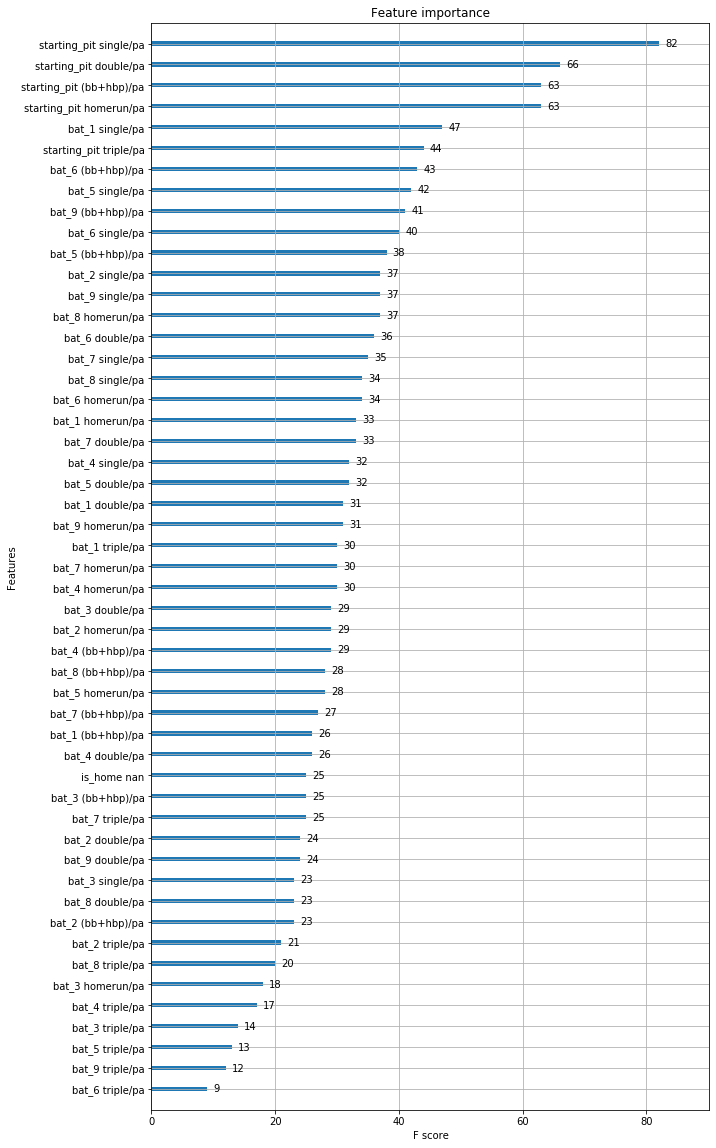

In [25]:
# Show feature importances.
xg_reg = xgb.train(params=params, dtrain=dmatrix, num_boost_round=30)
plt.rcParams["figure.figsize"] = (10, 20)
xgb.plot_importance(xg_reg)